In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
import importlib
for module in ['kooplearn', 'matplotlib']:
    try:
        importlib.import_module(module)
    except ImportError:
        %pip install {module}

In [2]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/Dynamical_system/data')
data_2019 = pd.read_csv('data_2019.csv',sep=';')
data_2020 = pd.read_csv('data_2020.csv',sep=';')
data_2021 = pd.read_csv('data_2021.csv',sep=';')
data_2022 = pd.read_csv('data_2022.csv',sep=';')
prices = pd.read_csv('France.csv')
os.chdir(actual_path)

/tmp/ipykernel_4564/128724526.py:5: DtypeWarning: Columns (36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2021 = pd.read_csv('data_2021.csv',sep=';')


In [3]:
whole_data = pd.concat([data_2019,data_2020,data_2021,data_2022])

In [4]:
whole_data = whole_data.reset_index(drop=True)

In [5]:
list_to_drop = ['Périmètre','Prévision J-1','Prévision J',
                ' Stockage batterie',
                'Déstockage batterie','Eolien terrestre',
                'Eolien offshore',
                'Unnamed: 40','Nature']
#the variables related to the batteries and both the ones 
#containing informations about offshore and onshore
#wind are deleted because they only contain NaN values

In [6]:
use_data = whole_data.drop(list_to_drop,axis=1).copy()

In [7]:
use_data = use_data.dropna()

In [8]:
use_data.loc[:, 'Heures'] = use_data['Heures'].apply(lambda x: f"{x}:00" if len(x.split(':')) == 2 else x)
use_data['Heures'] = pd.to_timedelta(use_data['Heures'])

In [9]:
use_data['date'] = pd.to_datetime(use_data['Date']) + use_data['Heures']

In [10]:
use_data.drop(['Heures'],axis=1,inplace=True)

In [11]:
prices_period = prices[prices['Datetime (Local)'] >= '2019-01-01 00:00:00'].copy()

In [12]:
prices_period

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
35063,France,FRA,2018-12-31 23:00:00,2019-01-01 00:00:00,51.00
35064,France,FRA,2019-01-01 00:00:00,2019-01-01 01:00:00,46.27
35065,France,FRA,2019-01-01 01:00:00,2019-01-01 02:00:00,39.78
35066,France,FRA,2019-01-01 02:00:00,2019-01-01 03:00:00,27.87
35067,France,FRA,2019-01-01 03:00:00,2019-01-01 04:00:00,23.21
...,...,...,...,...,...
87617,France,FRA,2024-12-29 17:00:00,2024-12-29 18:00:00,134.40
87618,France,FRA,2024-12-29 18:00:00,2024-12-29 19:00:00,133.72
87619,France,FRA,2024-12-29 19:00:00,2024-12-29 20:00:00,123.92
87620,France,FRA,2024-12-29 20:00:00,2024-12-29 21:00:00,118.59


In [13]:
prices_period.drop(['Country','ISO3 Code','Datetime (UTC)'],axis=1,inplace=True)

In [14]:
prices_period['Datetime (Local)'] = pd.to_datetime(prices_period['Datetime (Local)'])
whole_period = prices_period.merge(use_data,how='left',left_on='Datetime (Local)',
                                  right_on='date')

In [15]:
whole_period.drop('Datetime (Local)',axis=1,inplace=True)

In [16]:
whole_period.columns

Index(['Price (EUR/MWhe)', 'Date', 'Consommation', 'Fioul', 'Charbon', 'Gaz',
       'Nucléaire', 'Eolien', 'Solaire', 'Hydraulique', 'Pompage',
       'Bioénergies', 'Ech. physiques', 'Taux de Co2', 'Ech. comm. Angleterre',
       'Ech. comm. Espagne', 'Ech. comm. Italie', 'Ech. comm. Suisse',
       'Ech. comm. Allemagne-Belgique', 'Fioul - TAC', 'Fioul - Cogén.',
       'Fioul - Autres', 'Gaz - TAC', 'Gaz - Cogén.', 'Gaz - CCG',
       'Gaz - Autres', 'Hydraulique - Fil de l?eau + éclusée',
       'Hydraulique - Lacs', 'Hydraulique - STEP turbinage',
       'Bioénergies - Déchets', 'Bioénergies - Biomasse',
       'Bioénergies - Biogaz', 'date'],
      dtype='object')

In [17]:
whole_period.columns = ['price','date_wo_h','conso','fioul','coal','gas',
                       'nuclear','wind','sun','hydro','pump','bioenergy','physics',
                        'exchange_uk','exchange_sp','exchange_it','exchange_sw',
                        'exchange_gr','co2_rate','fioul_tac','fioul_cogen',
                        'fioul_other','gas_tac',
                       'gas_cogen','gas_ccg','gas_other','hydro_river','hydro_lake',
                       'hydro_turbine','bio_waste','bio_biomass','bio_biogas','date']

In [18]:
whole_period.dropna(inplace=True)

In [19]:
#whole_period['target_date'] = whole_period['date'] + timedelta(days=1)

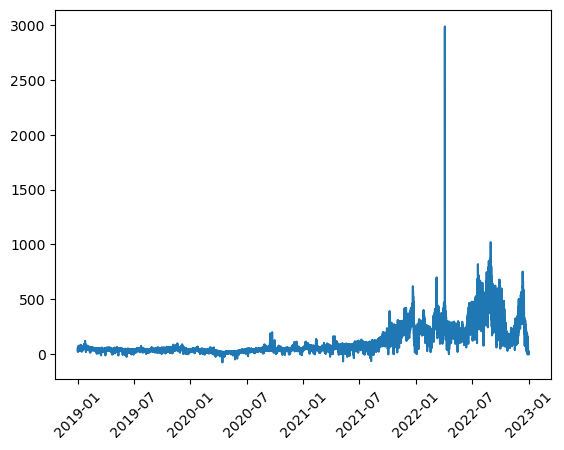

In [20]:
fig, ax = plt.subplots()
ax.plot(whole_period['date'],whole_period['price'])
ax.tick_params(axis='x', labelrotation=45)

In [21]:
%run functions.ipynb

In [22]:
whole_period['cos_day'] = whole_period['date'].dt.day.astype(float)
whole_period['sin_day'] = whole_period['date'].dt.day.astype(float)
whole_period['cos_month'] = whole_period['date'].dt.month.astype(float)
whole_period['sin_month'] = whole_period['date'].dt.month.astype(float)

In [23]:
whole_period['cos_day'] = cos_transformer(365).fit_transform(whole_period['cos_day'])
whole_period['cos_month'] = cos_transformer(12).fit_transform(whole_period['cos_month'])
whole_period['sin_day'] = sin_transformer(365).fit_transform(whole_period['sin_day'])
whole_period['sin_month'] = sin_transformer(12).fit_transform(whole_period['sin_month'])

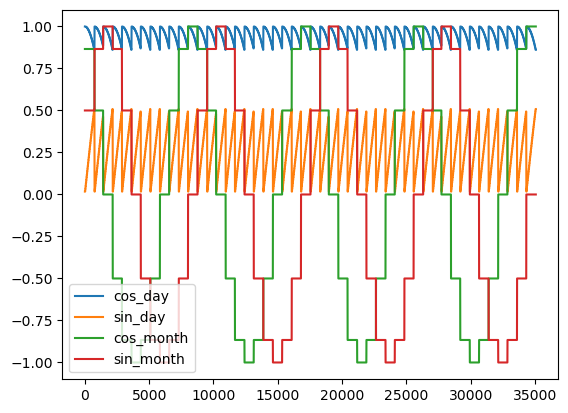

In [24]:
fig, ax = plt.subplots()
for i in ['cos_day','sin_day','cos_month','sin_month']:
    ax.plot(whole_period[f'{i}'],label=f'{i}')
    ax.legend()

In [25]:
#whole_period[whole_period['date'] < '2019-01-02 01:00:00' & whole_period['date'] <'2019-01-03 01:00:00' ]

In [26]:
whole_period['weekdays'] = whole_period['date'].dt.dayofweek
whole_period['weekend'] = np.zeros(whole_period.shape[0])
whole_period['not_weekend'] = np.zeros(whole_period.shape[0])
whole_period['date_wo_h'] = pd.to_datetime(whole_period['date_wo_h'])

In [27]:
for i in range(whole_period.shape[0]):
    if whole_period.loc[i,'weekdays'] == 5 or whole_period.loc[i,'weekdays'] == 6:
        whole_period.loc[i,'weekend'] = 1
    else:
        whole_period.loc[i,'not_weekend'] = 1

In [28]:
#we need to add the 2 days lagged of fossil fuel and nuclear production
#we cannot add what they call the announced availability because they don't 
#describe how they find it and on the majority of ressources concerning 
#the matter, we only have access to the effective production

In [29]:
whole_period['2_lags_coal'] = whole_period['coal'].shift(48)
whole_period['2_lags_fioul'] = whole_period['fioul'].shift(48)
whole_period['2_lags_gas'] = whole_period['gas'].shift(48)
whole_period['2_lags_nuke'] = whole_period['nuclear'].shift(48)
whole_period['target_price'] = whole_period['price'].shift(24)

In [30]:
whole_period.dropna(inplace=True) #we just loose two days

In [31]:
whole_period.columns

Index(['price', 'date_wo_h', 'conso', 'fioul', 'coal', 'gas', 'nuclear',
       'wind', 'sun', 'hydro', 'pump', 'bioenergy', 'physics', 'exchange_uk',
       'exchange_sp', 'exchange_it', 'exchange_sw', 'exchange_gr', 'co2_rate',
       'fioul_tac', 'fioul_cogen', 'fioul_other', 'gas_tac', 'gas_cogen',
       'gas_ccg', 'gas_other', 'hydro_river', 'hydro_lake', 'hydro_turbine',
       'bio_waste', 'bio_biomass', 'bio_biogas', 'date', 'cos_day', 'sin_day',
       'cos_month', 'sin_month', 'weekdays', 'weekend', 'not_weekend',
       '2_lags_coal', '2_lags_fioul', '2_lags_gas', '2_lags_nuke',
       'target_price'],
      dtype='object')

In [32]:
training_data = whole_period[whole_period['date_wo_h'].dt.year < 2022].copy()
test_data = whole_period[whole_period['date_wo_h'].dt.year == 2022].copy()
list_imp_hours = [3,8,13,18,23]

In [33]:
training_data.drop(['date_wo_h','price'],axis=1,inplace=True)
test_data.drop(['date_wo_h','price'],axis=1,inplace=True)

In [34]:
training_data = training_data[training_data['date'].dt.hour.isin(list_imp_hours)]
test_data = test_data[test_data['date'].dt.hour.isin(list_imp_hours)]

In [35]:
quantile_reg_05 = QuantileRegressor(quantile=0.05).fit(X=training_data.drop(['target_price','date'],axis=1),
                                                      y=training_data['target_price'])
quantile_reg_95 = QuantileRegressor(quantile=0.95).fit(X=training_data.drop(['target_price','date'],axis=1),
                                                      y=training_data['target_price'])

In [36]:
predictions_05 = quantile_reg_05.predict(X=test_data.drop(['target_price','date'],axis=1))
predictions_95 = quantile_reg_95.predict(X=test_data.drop(['target_price','date'],axis=1))

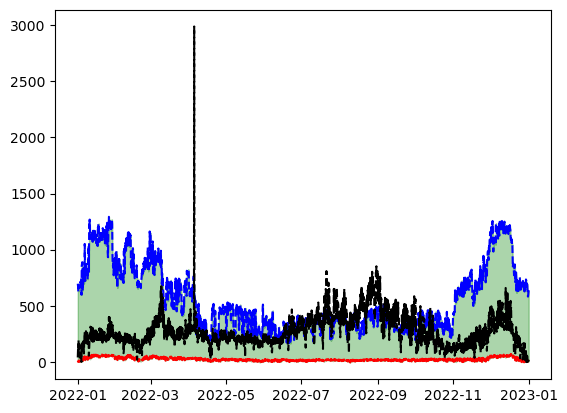

In [37]:
fig, ax = plt.subplots()
ax.plot(test_data['date'],predictions_05,'r--')
ax.plot(test_data['date'],predictions_95,'b--')
ax.plot(test_data['date'],test_data['target_price'],'k--')
ax.fill_between(x=test_data['date'],y1=predictions_05,y2=predictions_95,color='green',alpha=0.33)

In [38]:
np.mean(predictions_95-predictions_05)

np.float64(535.7115042444534)